In [3]:
%matplotlib inline

# Version 2 du modèle prédictif

Dans ce notebook, nous allons améliorer le modèle V1 en prenant en compte d'autres prédicteurs dans le modèle linéaire. 

On commence par importer les données dont on aura besoin (le tout est rassemblé en une seule cellule cette fois-ci) :

In [85]:
import pandas as pd
import numpy as np

league = pd.read_csv('data\\league.csv', index_col=0)
team = pd.read_csv('data\\team.csv', index_col=0)
match = pd.read_csv('data\\match.csv', index_col=0, parse_dates=[6], infer_datetime_format=True)

match.drop(['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 
            'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'], 
           axis=1, inplace=True)

match.drop(['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 
            'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10',
            'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 
            'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 
            'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 
            'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 
            'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 
            'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 
            'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1',
            'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 
            'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2',
            'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 
            'away_player_9', 'away_player_10', 'away_player_11'],
          axis=1, inplace=True)

match.drop(['country_id', 'season', 'stage', 'match_api_id'],
           axis=1, inplace=True)

match = match.merge(team[['team_api_id', 'team_long_name']] , left_on='home_team_api_id', right_on='team_api_id')
match.rename(columns={'team_long_name': 'home_team_long_name'}, inplace=True)
match = match.merge(team[['team_api_id', 'team_long_name']] , left_on='away_team_api_id', right_on='team_api_id')
match.rename(columns={'team_long_name': 'away_team_long_name'}, inplace=True)

match.drop(['team_api_id_y', 'team_api_id_x'], axis=1, inplace=True)

# On trie par date et on reindex
match.sort_values(by='date', inplace=True)


# On va tout de suite filtrer sur la ligue 1, l'extraction des features prend trop de temps sinon
#match = match[match.league_id == 4769]

match.index = range(0,len(match))

match.head()

,id,league_id,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,home_team_long_name,away_team_long_name
0,24559,24558,2008-07-18,10192,9931,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BSC Young Boys,FC Basel
1,24560,24558,2008-07-19,9930,10179,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC Aarau,FC Sion
2,24561,24558,2008-07-20,10199,9824,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC Luzern,FC Vaduz
3,24562,24558,2008-07-20,7955,10243,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Neuchâtel Xamax,FC Zürich
4,24615,24558,2008-07-23,10243,10199,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC Zürich,FC Luzern


On va maintenant construire les nouvelles variables à partir des informations à disposition, à savoir :
- le temps de récupération (ie. le nombre de jours entre le dernier match et le jour j)
- le nombre de matchs dans le mois
- la dynamique : c'est l'historique des 5 derniers matchs (ex: GGPPN)
- le nombre de buts ajustés : on va pour cela considérer
    - les buts qui permettent à une équipe de mener compte 1.2
    - les tirs cadrés par rapport à la position (distance + angle) (pondération à définir)
    - somme tirs cadrés + tirs non cadrés
    - ratio tirs cadrés / tirs non cadrés
    - compter 0.8 un but quand l'équipe adverse s'est prise en carton rouge
    - corner, coup franc indirect comptent pour 0.1 ?
    

In [93]:
match_ligue_1 = match[match.league_id == 4769]

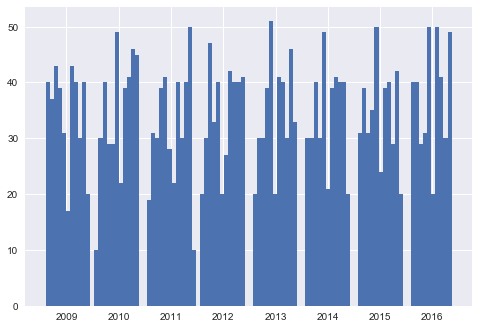

In [100]:
match_ligue_1.date.hist(bins=100)

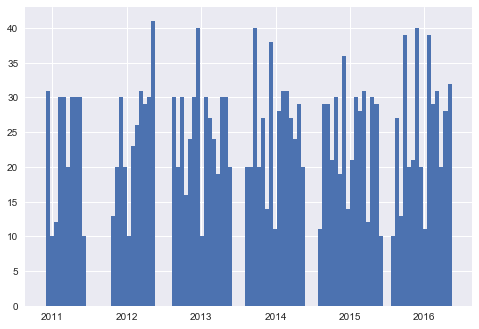

In [99]:
match_ligue_1[match_ligue_1.isnull().goal == False].date.hist(bins=100)

## Conditions du match

Commençons par le temps de récupération :

In [180]:
def calcul_recup(row, home=True):    
    # on récupère l'équipe et la date du match
    if home:
        equipe, jourJ = (row.home_team_api_id, row.date)
    else:
        equipe, jourJ = (row.away_team_api_id, row.date)
      
    # on récupère tous les matchs précédents de l'équipe
    match_precedents = match[:row.name][(match.home_team_api_id == equipe) | (match.away_team_api_id == equipe)]
    
    # Si il n'y en a aucun, on compte le maximum de récupération, sinon on retourne le nombre de jours
    if match_precedents.id.count() == 0:
        return 15
    else:
        deltaT = np.min(jourJ - match_precedents.date)
        return min(deltaT.days, 15)
    
match['recuperation_home'] = match.apply(lambda row: calcul_recup(row), axis=1)
match['recuperation_away'] = match.apply(lambda row: calcul_recup(row, home=False), axis=1)

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


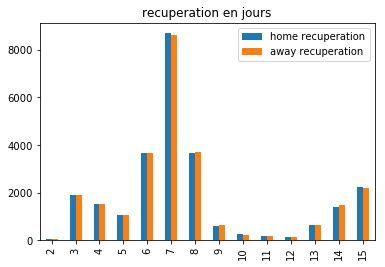

In [181]:
df_home = pd.DataFrame(match['recuperation_home'].value_counts()).sort_index()
df_away = pd.DataFrame(match['recuperation_away'].value_counts()).sort_index()

#on merge les deux
df_home_away = df_home.merge(df_away, how='outer', left_index=True, right_index=True)
df_home_away.columns = ['home recuperation', 'away recuperation']

#on affiche les deux histogrammes
df_home_away.plot(kind='bar', title='recuperation en jours')

On peut regarder si on observe une tendance quand le nombre de jours de repos augmente :

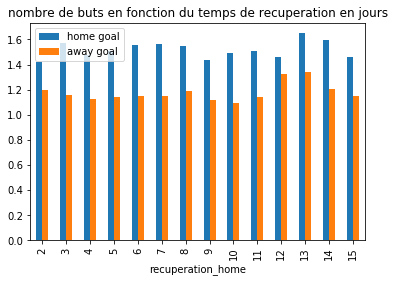

In [182]:
df_home = pd.DataFrame(match[['recuperation_home','home_team_goal']].groupby(by='recuperation_home').mean()).sort_index()
df_away = pd.DataFrame(match[['recuperation_away','away_team_goal']].groupby(by='recuperation_away').mean()).sort_index()

#on merge les deux
df_home_away = df_home.merge(df_away, how='outer', left_index=True, right_index=True)
df_home_away.columns = ['home goal', 'away goal']

#on affiche les deux histogrammes
df_home_away.plot(kind='bar', title='nombre de buts en fonction du temps de recuperation en jours')

On observe pas vraiment d'effet, sauf peut être sur la fin...

On calcule maintenant la dynamique :

In [183]:
def vainqueur(row):
    if row.home_team_goal > row.away_team_goal:
        return 'H'
    elif row.home_team_goal > row.away_team_goal:
        return 'A'
    else:
        return 'N'
    
match['vainqueur'] = match.apply(vainqueur, axis=1)

In [184]:
def dynamique(row, home=True):
    # on récupère l'équipe et la date du match
    if home:
        equipe, jourJ = (row.home_team_api_id, row.date)
    else:
        equipe, jourJ = (row.away_team_api_id, row.date)
        
    match_precedents = match[:row.name][(match.home_team_api_id == equipe) | (match.away_team_api_id == equipe)]
    
    # On trie par date et on reindex pour être sur
    match_precedents.sort_values(by='date', inplace=True)
    match_precedents.index = range(0,len(match_precedents))
    
    dyn = ''
    # On prend maximum les 5 derniers matchs
    for i in range(min(5,match_precedents.id.count())):
        row = match_precedents.iloc[[i]]
        # Si l'équipe qu'on regarde a joué à domicile
        if equipe == row.home_team_api_id.values:
            if row.vainqueur.values == 'H':
                dyn += 'G'
            elif row.vainqueur.values == 'A':
                dyn += 'P'
            else:
                dyn += 'N'
        # Sinon c'est que c'était l'équipe qui jouait à l'exterieur
        else:
            if row.vainqueur.values == 'A':
                dyn += 'G'
            elif row.vainqueur.values == 'H':
                dyn += 'P'
            else:
                dyn += 'N'
    
    # Si il n'existe pas de match avant, on rempli par des matchs nuls            
    if len(dyn) < 5:
        dyn = dyn + ('N' * (5-len(dyn)))
        
    return dyn[::-1] # on renverse la chaine de caractère, car on veut du plus vieux au plus jeune de gauche à droite
    
match['home_dynamique'] = match.apply(lambda row: dynamique(row), axis=1)
match['away_dynamique'] = match.apply(lambda row: dynamique(row, home=False), axis=1)

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [185]:
def score_dyn(dyn):
    score = 0
    for i in range(5):
        score = score + (1 if dyn[i] == 'G' else -1 if dyn[i] == 'P' else 0) * (float(i+1)/float(5))
    return score

match['home_score_dynamique'] = match.home_dynamique.apply(score_dyn)
match['away_score_dynamique'] = match.away_dynamique.apply(score_dyn)

On enregistre la nouvelle base de données (le calcul a pris des heures, on va pas le faire à chaque fois...)

In [186]:
match.to_csv('data\\match_enhanced_global.csv', encoding='utf-8')

## Ajustement nombre de buts

Maintenant on va chercher à améliorer l'information sur les buts. On avait vu que celle-ci était trop variable et pas toujours représentative de la qualité de jeu de l'équipe. 

Commençons par charger les données :

In [5]:
match = pd.read_csv('data\\match_enhanced_global.csv', index_col=0, parse_dates=[3], infer_datetime_format=True)

On commence par importer la librairie nécessaire pour parser les informations contenues dans les colonnes 'goal', 'shoton', 'possession', etc.

In [6]:
from lxml import html
import scipy

On extrait le nombre de tirs cadrés de la colonne 'shoton'. Pour ceci on procède en deux étapes :
- on récupère d'abord la liste des équipes qui ont fais des tirs cadrés (ex: [equipe 1, equipe 1, equipe 2] signfie que l'equipe 1 a d'abord marqué deux fois, puis l'équipe 2 a marqué une fois)
- on aggrège la liste pour avoir deux colonnes : equipe_home_tirs_cadres = 2, equipe_away_tir_cadres = 1

In [7]:
def extract_nb_tirs(row):
    if(not pd.isnull(row)):
        tree = html.fromstring(row)
        equipe = tree.xpath('//team/text()')
        return np.array(equipe, dtype=np.int32)
    return []

match['tirs_cadres'] = match.shoton.apply(lambda row: extract_nb_tirs(row))

In [8]:
match.tirs_cadres.tail()

25974    []
25975    []
25976    []
25977    []
25978    []
Name: tirs_cadres, dtype: object

In [9]:
def agrege_equipe_cadres(row, home=True):
    if(len(row.tirs_cadres) > 0):
        if home:
            return (row.tirs_cadres == row.home_team_api_id).sum()
        else:
            return (row.tirs_cadres == row.away_team_api_id).sum()
    return 0
    
match['home_tir_cadre'] = match.apply(lambda row: agrege_equipe_cadres(row), axis=1)
match['away_tir_cadre'] = match.apply(lambda row: agrege_equipe_cadres(row, home=False), axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000028A2C518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000031C65E48>]], dtype=object)

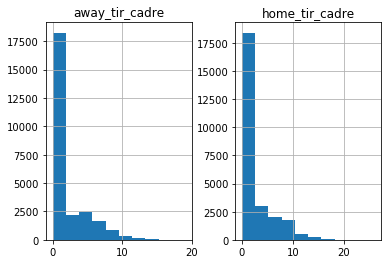

In [10]:
match[['home_tir_cadre','away_tir_cadre']].hist()

On remarque un problème : certaines lignes n'avaient pas l'information sur les tirs (non) cadrés. Il existe donc des lignes où le nombre de buts est différent de 0, mais où il n'y a pas l'information sur le nombre de tirs (non) cadrés. On va donc estimer le nombre de tirs cadrés en faisant nb_de_buts * coeff où coeff suit une loi de poisson centrée sur la moyenne de tirs cadrés il faut par but

In [11]:
print(match[match.home_tir_cadre!=0].home_tir_cadre.sum()/float(match[match.home_tir_cadre!=0].home_team_goal.sum()))
print(match[match.away_tir_cadre!=0].away_tir_cadre.sum()/float(match[match.away_tir_cadre!=0].away_team_goal.sum()))

3.96485768501
4.28038830941


On va donc considérer les coefficients suivants :

In [12]:
def adjust_cadre(row, home=True):
    if home:
        if row.home_tir_cadre == 0 and row.home_team_goal != 0:
            return np.random.poisson(3.96 * row.home_team_goal)
        return row.home_tir_cadre
    else:
        if row.away_tir_cadre == 0 and row.away_team_goal != 0:
            return np.random.poisson(4.28 * row.home_team_goal)
        return row.away_tir_cadre
    
match['home_tir_cadre'] = match.apply(adjust_cadre, axis=1)
match['away_tir_cadre'] = match.apply(adjust_cadre, axis=1, home=False)

On a maintenant des distributions plus vraisemblables du nombre de tirs cadrés

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000313B78D0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000031A4A128>]], dtype=object)

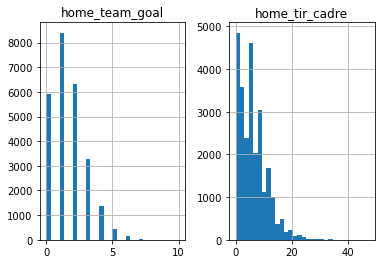

In [13]:
match[['home_team_goal','home_tir_cadre']].hist(bins=30)

Passons à une autre correction : on va déterminer les tirs qui ont donné l'avantage. En effet, ce sont ceux qui ont "le plus de valeur". Lorsque les deux équipes sont à égalités, elles jouent du mieux possible pour prendre l'avantage et remporter le match. A l'inverse, une équipe menée 4-0 aura tendance en fin de match à se décourager et par conséquent se prendre encore plus de buts ! 

Le calcul est un peu long, mais l'idée est de récupérer l'ordre dans lequel les buts sont arrivés, puis de compter combien de fois chacune des équipes à marqué alors qu'il y avait égalité.

In [14]:
def compte_pencher_match(equipes):  
    # Si il y a eu une erreure, on renvoie []
    if(len(np.unique(equipes)) == 0):
        return []
    
    # Si seulement 1 équipe à marqué, on renvoie 1 pour cette équipe et 0 pour l'autre (convention -1)
    if(len(np.unique(equipes)) == 1):
        [equipe1] = np.unique(equipes)
        return(np.array([[equipe1,1],[-1,0]]))
   
    # sinon
    else:
        equipe1, equipe2 = np.unique(equipes)
        
        # variable qui suit le nombre de buts marqués par chaque équipe
        count_equipe1 = 0
        count_equipe2 = 0

        # nombre de fois que chaque équipe a pris l'avantage
        penche_equipe1 = 0
        penche_equipe2 = 0

        for equipe in equipes:
            # Si équipe 1 marque
            if(equipe == equipe1):
                # Si il y avait égalité, on rajoute un point de 'prise avantage'
                if(count_equipe1 == count_equipe2):
                    penche_equipe1 = penche_equipe1 + 1
                # Et on compte le but
                count_equipe1 = count_equipe1 + 1
                
            # A l'inverse si equipe 2 marque, on fait le même test
            else:
                if(count_equipe1 == count_equipe2):
                    penche_equipe2 = penche_equipe2 + 1
                count_equipe2 = count_equipe2 + 1
            

        return(np.array([[equipe1,penche_equipe1],[equipe2,penche_equipe2]]))


# cette fonction extrait le nombre de fois où une équipe (home et away) a fait pencher le match en sa faveur
def ajuste_goals(cell):
    # on retire les lignes qui n'ont pas cette donnée de renseigné
    if(not pd.isnull(cell)):
        # on garde uniquement les lignes où il y a eu des buts (sinon pas d'effet supplémentaire)
        if(cell.startswith('<goal>')):
            tree = html.fromstring(cell)
            equipe = tree.xpath('//team/text()')
            return compte_pencher_match(np.array(equipe, dtype=np.int32))
    return []

match['avantage'] = match.goal.apply(lambda cell: ajuste_goals(cell))

def get_home_away(row, home=True):
    if(row.avantage == []):
        return 0
    else:
        (equipe1, score1), (equipe2, score2) = row.avantage
        if home:
            if equipe1 == row.home_team_api_id:
                return score1
            return score2
        else:
            if equipe1 == row.away_team_api_id:
                return score1
            return score2

match['home_avantage'] = match.apply(lambda row: get_home_away(row), axis=1)
match['away_avantage'] = match.apply(lambda row: get_home_away(row, home=False), axis=1)

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:56: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000031F74E48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000329EB208>]], dtype=object)

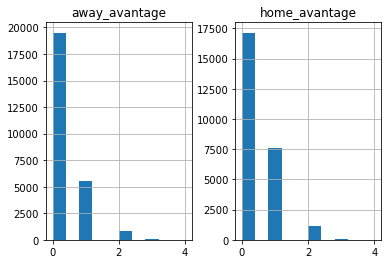

In [15]:
match[['home_avantage','away_avantage']].hist()

On va maintenant comptabiliser le nombre de corner

In [16]:
def extract_nb_corner(cell):
    if(not pd.isnull(cell)):
        tree = html.fromstring(cell)
        equipe = tree.xpath('//team/text()')
        return np.array(equipe, dtype=np.int32)
    return []

match['nb_corner'] = match.corner.apply(lambda cell: extract_nb_corner(cell))

In [17]:
def agrege_equipe_corner(row, home=True):
    if(len(row.nb_corner) > 0):
        if home:
            return (row.nb_corner == row.home_team_api_id).sum()
        else:
            return (row.nb_corner == row.away_team_api_id).sum()
    return 0
    
match['home_corner'] = match.apply(lambda row: agrege_equipe_corner(row), axis=1)
match['away_corner'] = match.apply(lambda row: agrege_equipe_corner(row, home=False), axis=1)

De la même manière il faut redresser quand on a pas l'information. On va mettre la moyenne cette fois-ci :

In [18]:
print(match[match.home_corner != 0].home_corner.mean())
print(match[match.away_corner != 0].away_corner.mean())

5.90802675585
4.64515346354


In [19]:
def adjust_corner(row, home=True):
    if home:
        if row.nb_corner == []:
            return np.random.poisson(5.91)
        return row.home_corner
    else:
        if row.nb_corner == []:
            return np.random.poisson(4.65)
        return row.away_corner
    
match['home_corner'] = match.apply(lambda row: adjust_corner(row), axis=1)
match['away_corner'] = match.apply(lambda row: adjust_corner(row, home=False), axis=1)

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  app.launch_new_instance()
C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


C'est moyennement satisfaisant ... on verra si on conserve

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000032CBB5C0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000032DF6A90>]], dtype=object)

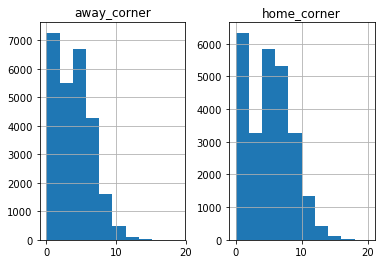

In [20]:
match[['home_corner','away_corner']].hist()

On sait que 2.2% des corners sont transformés en buts (source : http://www.slate.fr/sports/87357/corners-occasion-but-football). (le dataset ne permet pas de mesurer cela). On calcule alors la métrique finale

In [36]:
def calcul_but_ajuste(row, home=True):
    # Si on avais pas l'information sur les buts par exemple, on utilse les données des 'vrais' buts
    if row.isnull().goal == True:
        if home:
            return row.home_team_goal
        else:
            return row.away_team_goal
    # Sinon on utilise les données enrichies qu'on a créée:
    if home:    
        return row.home_tir_cadre * 0.25 + row.home_corner * 0.022 + row.home_avantage * 0.5
    else:
        return row.away_tir_cadre * 0.25 + row.away_corner * 0.022 + row.away_avantage * 0.5
    
match['home_goal_adjusted'] = match.apply(lambda row: calcul_but_ajuste(row), axis=1)
match['away_goal_adjusted'] = match.apply(lambda row: calcul_but_ajuste(row, home=False), axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000033619C88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000350A0F28>]], dtype=object)

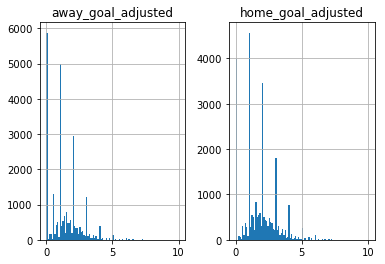

In [37]:
match[['home_goal_adjusted','away_goal_adjusted']].hist(bins=100)

On va maintenant se limiter à la ligue 1 française dans un premier temps

In [38]:
match_ligue_1 = match[match.league_id == 4769]
num_teams = len(match_ligue_1.away_team_api_id.unique())
print(num_teams)

35


In [39]:
match.drop(['id','league_id','date','goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession',
           'avantage','nb_corner','tirs_cadres'],
           axis=1, inplace=True)

In [40]:
match

,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_long_name,away_team_long_name,recuperation_home,recuperation_away,vainqueur,home_dynamique,...,home_score_dynamique,away_score_dynamique,home_tir_cadre,away_tir_cadre,home_avantage,away_avantage,home_corner,away_corner,home_goal_adjusted,away_goal_adjusted
0,10192,9931,1,2,BSC Young Boys,FC Basel,15,15,N,NNNNN,...,0.0,0.0,1,3,0,0,7,2,1.000,2.000
1,9930,10179,3,1,FC Aarau,FC Sion,15,15,H,NNNNN,...,0.0,0.0,8,12,0,0,7,9,3.000,1.000
2,10199,9824,1,2,FC Luzern,FC Vaduz,15,15,N,NNNNN,...,0.0,0.0,6,3,0,0,5,8,1.000,2.000
3,7955,10243,1,2,Neuchâtel Xamax,FC Zürich,15,15,N,NNNNN,...,0.0,0.0,1,3,0,0,5,5,1.000,2.000
4,10243,10199,1,0,FC Zürich,FC Luzern,3,3,H,NNNNN,...,0.0,0.0,1,0,0,0,11,6,1.000,0.000
5,6493,7955,1,2,AC Bellinzona,Neuchâtel Xamax,15,3,N,NNNNN,...,0.0,0.0,2,10,0,0,9,1,1.000,2.000
6,9931,9956,1,0,FC Basel,Grasshopper Club Zürich,5,15,H,NNNNN,...,0.0,0.0,4,0,0,0,7,1,1.000,0.000
7,10179,10192,2,1,FC Sion,BSC Young Boys,5,6,H,NNNNP,...,-1.0,-1.0,5,10,0,0,6,7,2.000,1.000
8,9824,9930,0,2,FC Vaduz,FC Aarau,4,5,N,NNNNN,...,0.0,0.0,0,0,0,0,3,5,0.000,2.000
9,10199,7955,0,1,FC Luzern,Neuchâtel Xamax,3,3,N,NNNPN,...,-0.8,-0.8,0,0,0,0,5,6,0.000,1.000


## Construction du modèle

Maintenant que les données sont propres et identifiées, on va construire le modèle pymc3. Pour cela, il faut changer les noms des équipes en indices allant de 1 au nombre total d'équipe

In [41]:
teams = match_ligue_1.home_team_long_name.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

In [42]:
teams

,team,i
0,AS Monaco,0
1,AJ Auxerre,1
2,Valenciennes FC,2
3,Stade Rennais FC,3
4,FC Sochaux-Montbéliard,4
5,Le Havre AC,5
6,Le Mans FC,6
7,Girondins de Bordeaux,7
8,AS Nancy-Lorraine,8
9,Olympique Lyonnais,9


In [43]:
match_ligue_1 = pd.merge(match_ligue_1, teams, left_on='home_team_long_name', right_on='team', how='left')
match_ligue_1 = match_ligue_1.rename(columns = {'i': 'i_home'}).drop('team', 1)
match_ligue_1 = pd.merge(match_ligue_1, teams, left_on='away_team_long_name', right_on='team', how='left')
match_ligue_1 = match_ligue_1.rename(columns = {'i': 'i_away'}).drop('team', 1)

In [44]:
match_ligue_1.head()

,id,league_id,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,goal,shoton,shotoff,...,avantage,home_avantage,away_avantage,nb_corner,home_corner,away_corner,home_goal_adjusted,away_goal_adjusted,i_home,i_away
0,4774,4769,2008-08-09,9829,9847,1,0,NaN,NaN,NaN,...,[],0,0,[],9,6,1.0,0.0,0,12
1,4769,4769,2008-08-09,8583,9830,2,1,NaN,NaN,NaN,...,[],0,0,[],2,6,2.0,1.0,1,16
2,4778,4769,2008-08-09,9873,9853,1,0,NaN,NaN,NaN,...,[],0,0,[],6,4,1.0,0.0,2,11
3,4776,4769,2008-08-09,9851,8592,4,4,NaN,NaN,NaN,...,[],0,0,[],5,3,4.0,4.0,3,18
4,4777,4769,2008-08-09,9874,9855,1,2,NaN,NaN,NaN,...,[],0,0,[],5,4,1.0,2.0,4,19


On split notre jeu de données (60/20/20) afin de pouvoir mesurer plus tard les perfomances des différents modèles testés. NB : on fait exprès de ne pas randomiser les individus qui iront en train/CV/test. En effet, les observations sont ordonnées dans le temps, et en application réelle, on a accès uniquement au passé pour prédire le futur.

In [78]:
# On compte le nombre d'observations dont on dispose
taille_totale = len(match_ligue_1.home_team_goal.values)
# on calcule le nombre d'observations que l'on envoie en training set
train_size = int(taille_totale*0.6)
CV_size = int(taille_totale*0.8)

observed_home_goals = match_ligue_1.home_goal_adjusted.values[:train_size]/float(4)
observed_away_goals = match_ligue_1.away_goal_adjusted.values[:train_size]/float(4)

home_team = match_ligue_1.i_home.values[:train_size]
away_team = match_ligue_1.i_away.values[:train_size]

home_recuperation = np.array(match_ligue_1.recuperation_home.values[:train_size], dtype=np.float64)
away_recuperation = np.array(match_ligue_1.recuperation_away.values[:train_size], dtype=np.float64)

home_dynamique = np.array(match_ligue_1.home_score_dynamique.values[:train_size], dtype=np.float64)
away_dynamique = np.array(match_ligue_1.away_score_dynamique.values[:train_size], dtype=np.float64)

On décrit notre modélisation. On commence par spécifier les entrées et sorties de notre modélisation ![title](illustrations/V1.png)

In [79]:
import theano
import numpy as np

model_input_team = theano.shared(np.array([home_team, away_team]))
model_input_conditions = theano.shared(np.array([home_recuperation, away_recuperation, home_dynamique, away_dynamique]))
model_output = theano.shared(np.array([observed_home_goals, observed_away_goals]))

Puis on écrit le modèle

In [83]:
import pymc3 as pm

model = pm.Model()
with pm.Model() as model:
    # Paramètres spécifiques à chaque équipe  
    attaque = pm.Normal("attaque", mu=0, sd=1, shape=num_teams)
    defense = pm.Normal("defense", mu=0, sd=1, shape=num_teams)
    
    # Paramètre lié aux conditions du match
    coeff_home = pm.Normal("coeff_home", mu=0, sd=1, shape=1)
    coeff_recup = pm.Normal("coeff_recup", mu=0, sd=1, shape=1)
    coeff_dynamique = pm.Normal("coeff_dynamique", mu=0, sd=1, shape=1)
    coeff_perf = pm.Normal("coeff_perf", mu=0, sd=1, shape=1)
    
    # et un intercept
    intercept = pm.Normal("intercept", mu=0, sd=1, shape=1)
    
    home_theta  = pm.math.exp(intercept + 
                              coeff_home + 
                              coeff_recup * (model_input_conditions[0] - model_input_conditions[1]) + 
                              coeff_dynamique * (model_input_conditions[2] - model_input_conditions[3]) +
                              coeff_perf * (attaque[model_input_team[0]] - defense[model_input_team[1]])
                              )
    away_theta  = pm.math.exp(intercept + 
                              coeff_recup * (model_input_conditions[1] - model_input_conditions[0]) +
                              coeff_dynamique * (model_input_conditions[3] - model_input_conditions[2]) +
                              coeff_perf * (attaque[model_input_team[1]] - defense[model_input_team[0]])
                             )

    # likelihood of observed data 
    home_points = pm.Gamma('home_points', alpha=home_theta, beta=1, observed=model_output[0])
    away_points = pm.Gamma('away_points', alpha=away_theta, beta=1, observed=model_output[1])

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -inf: 100%|██████████████████████████████████████████████████████| 20000/20000 [00:44<00:00, 444.93it/s]
Finished [100%]: Average ELBO = -inf
100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 166.22it/s]


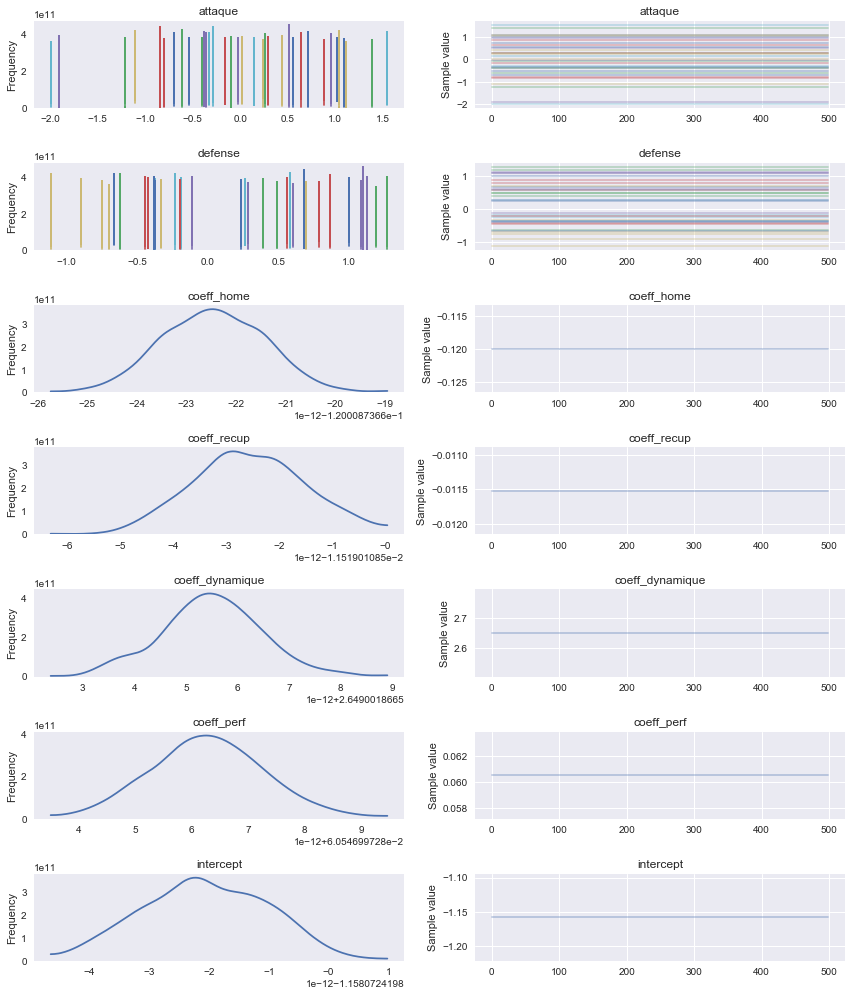

In [84]:
with model:
    trace = pm.sample(500, n_init=20000)

    pm.traceplot(trace)

La phase de sampling étant terminé, on va afficher pour chaque équipe la ditribution à posteriori des paramètres d'attaque et de défense sous forme de forestplot : 

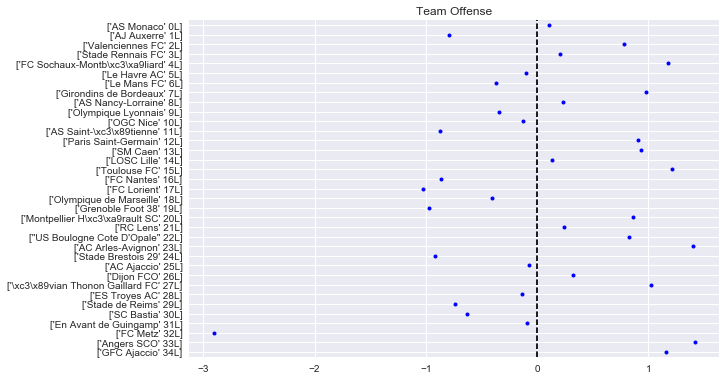

In [82]:
pm.forestplot(trace[10:], varnames=['attaque'], ylabels=teams.values, main="Team Offense", chain_spacing=0.2)

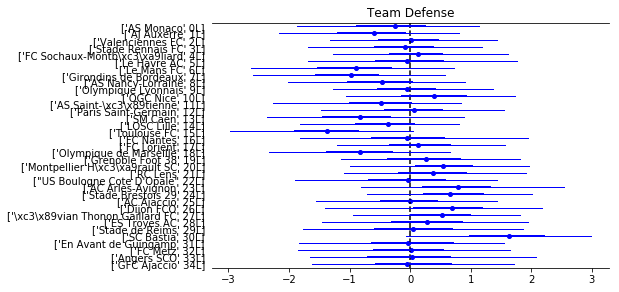

In [50]:
pm.forestplot(trace[10:], varnames=['defense'], ylabels=teams.values, main="Team Defense", chain_spacing=0.2)

Les résultats semblent cohérents (le trio de tête est PSG - OL - OM), passons à la prédiction d'un nouveau match.

# Prédiction de l'issue d'un match

On cherche à prédire l'issue d'un match. Pour cela, on change les paramètres d'entrée, et on relance notre modèle : (ici : PSG contre Grenoble (indice 18 vs indice 17), on s'attend à voir le PSG gagner..

In [51]:
model_input_team.set_value(np.array([[18],[17]]))
model_input_conditions.set_value([[1],[7],[2],[-2]])

Et on sample depuis notre modèle avec les nouvelles entrées

In [52]:
ppc = pm.sample_ppc(trace[10:], model=model, samples=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  4.77it/s]


On fait un peu de mise en forme des résultats afin de pouvoir les exploiter simplement

In [53]:
away = pd.DataFrame(ppc['away_points'])
home = pd.DataFrame(ppc['home_points'])  

prediction_score = home.merge(away, how='inner', left_index=True, right_index=True)
prediction_score.columns = ['home_points', 'away_points']

In [54]:
prediction_score.head()

,home_points,away_points
0,0,0
1,0,0
2,117,0
3,0,1
4,0,0


In [55]:
def vainqueur(row):
    if row[0] > row[1]:
        return 'H'
    elif row[0] < row[1]:
        return 'A'
    else:
        return 'N'

prediction_score['vainqueur'] = prediction_score.apply(vainqueur, axis=1)

In [56]:
prediction_score.head()

,home_points,away_points,vainqueur
0,0,0,N
1,0,0,N
2,117,0,H
3,0,1,A
4,0,0,N


In [57]:
prediction_score.vainqueur.value_counts()

N    47
H    34
A    19
Name: vainqueur, dtype: int64

On calcule les probabilités associées

In [58]:
100 * prediction_score.vainqueur.value_counts() / prediction_score.vainqueur.count()

N    47.0
H    34.0
A    19.0
Name: vainqueur, dtype: float64

Le PSG (home ici) a 77.9% de chances de l'emporter. 

On va enfin calculer le résultat le plus probable (les buts encaissés pour chacune des équipes). Une rapide visualisation nous montre que le résultat le plus probable est 2-0. Vérifions le :

C:\Users\Alexis\Anaconda2\lib\site-packages\numpy\ma\core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


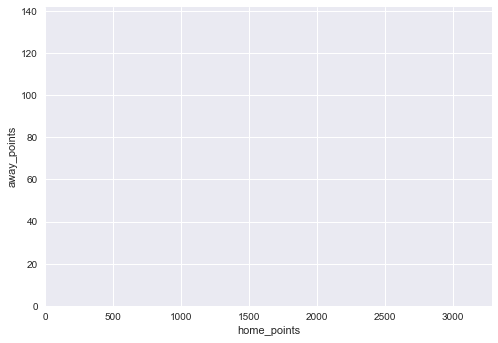

In [59]:
import seaborn
seaborn.kdeplot(data=prediction_score.home_points, data2=prediction_score.away_points, shade=True)

In [60]:
prediction_score.groupby(["home_points", "away_points"]).size()

home_points  away_points
0            0              47
             1               7
             2               5
             3               1
             4               1
             9               1
             15              1
             18              1
             44              1
             142             1
1            0               6
2            0               3
3            0               1
4            0               2
5            0               2
7            0               1
9            0               2
10           0               1
12           0               1
13           0               1
15           0               1
21           0               1
37           0               1
40           0               1
42           0               1
54           0               1
117          0               1
162          0               1
183          0               1
690          0               1
1547         0               1
1557         0

In [61]:
prediction_score.groupby(["home_points", "away_points"]).size().idxmax()

(0, 0)

In [62]:
100. * prediction_score.groupby(["home_points", "away_points"]).size().max() / prediction_score.vainqueur.count()

47.0

Conclusion, le résultat est cohérent, on s'attend à ce que le PSG l'emporte (77.9% de chances) avec un score de 2-0 (17.4 % de chances)

# Evaluation des perfomances du modèle

Maintenant que l'on a vu que notre modèle est fonctionnel (et cohérent !), nous allons dans cette dernière section évaluer notre modèle. On commence par récupérer les données de cross-validation :

In [63]:
observed_home_goals = match_ligue_1.home_goal_adjusted.values[train_size+1:CV_size]/float(4)
observed_away_goals = match_ligue_1.away_goal_adjusted.values[train_size+1:CV_size]/float(4)

home_team = match_ligue_1.i_home.values[train_size+1:CV_size]
away_team = match_ligue_1.i_away.values[train_size+1:CV_size]

home_recuperation = np.array(match_ligue_1.recuperation_home.values[train_size+1:CV_size], dtype=np.float64)
away_recuperation = np.array(match_ligue_1.recuperation_away.values[train_size+1:CV_size], dtype=np.float64)

home_dynamique = np.array(match_ligue_1.home_score_dynamique.values[train_size+1:CV_size], dtype=np.float64)
away_dynamique = np.array(match_ligue_1.away_score_dynamique.values[train_size+1:CV_size], dtype=np.float64)

Et on assigne ces nouveaux individus comme entrée et sortie de notre modèle

In [64]:
model_input_team.set_value(np.array([home_team,away_team], dtype=np.int32))
model_input_conditions.set_value(np.array([home_recuperation,away_recuperation,home_dynamique,away_dynamique], dtype=np.float64))

Et on tire 10000 réalisations pour chacun des matchs

In [65]:
ppc = pm.sample_ppc(trace[10:], model=model, samples=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  4.68it/s]


L'échantillon est désormais créer, on va maintenant comparer nos prédictions avec la réalité :

In [66]:
away_prediction = pd.DataFrame(ppc['away_points'])
home_prediction = pd.DataFrame(ppc['home_points'])  

On crée un dataframe pour chaque match (chacun contenant 10000 simulations)

In [67]:
prediction_score = [home_prediction[[i]].merge(away_prediction[[i]], 
                                               how='inner', 
                                               left_index=True, right_index=True) 
                    for i in range(len(home_team))]

for df in prediction_score:
    df.columns = ['home_prediction', 'away_prediction']

Pour chaque dataframe, on détermine l'équipe qui gagne

In [68]:
def vainqueur(row):
    if row[0] > row[1]:
        return 'H'
    elif row[0] < row[1]:
        return 'A'
    else:
        return 'N'

In [69]:
for df in prediction_score:
    df['prediction_vainqueur'] = df.apply(vainqueur, axis=1) 

On ajoute aussi le score le plus probable d'après nos simulations :

In [70]:
resultats = list()
    
for df in prediction_score:
    home_score, away_score = df.groupby(["home_prediction", "away_prediction"]).size().idxmax()
    resultats.append(
        [df.prediction_vainqueur.value_counts().idxmax(), home_score, away_score]
    )
    
resultats = pd.DataFrame(np.array(resultats))
resultats.columns = ['prediction_vainqueur', 'prediction_home_score', 'prediction_away_score']

#on remet les scores au type int, sinon il sont converti en 'objet' ...
resultats[['prediction_home_score', 'prediction_away_score']] = resultats[['prediction_home_score', 'prediction_away_score']].astype(np.int32)

On met en forme aussi les vrais résultats (ie. les observations)

In [71]:
vrai_home = pd.DataFrame(observed_home_goals)
vrai_away = pd.DataFrame(observed_away_goals)  

In [72]:
vrai_resultats = vrai_home.merge(vrai_away, how='inner', left_index=True, right_index=True)
vrai_resultats.columns = ['home_points', 'away_points']

vrai_resultats['vainqueur'] = vrai_resultats.apply(vainqueur, axis=1)

vrai_resultats = vrai_resultats.merge(resultats, how='inner', left_index=True, right_index=True)

On a enfin notre dataframe contenant les observations et les prédictions (gagnant + score) match par match :

In [73]:
vrai_resultats

,home_points,away_points,vainqueur,prediction_vainqueur,prediction_home_score,prediction_away_score
0,0.0000,0.1250,A,N,0,0
1,0.7500,1.1250,A,N,0,0
2,1.5625,0.0000,H,N,0,0
3,0.4375,0.0000,H,N,0,0
4,0.3750,0.1250,H,N,0,0
5,0.0000,0.0000,N,N,0,0
6,0.0000,0.1250,A,N,0,0
7,0.3125,0.4375,A,N,0,0
8,1.4375,1.1250,H,N,0,0
9,1.5625,0.8750,H,N,0,0


On calcule notre score :

In [74]:
from sklearn import metrics

metrics.accuracy_score(vrai_resultats.vainqueur.values, vrai_resultats.prediction_vainqueur.values)

0.090609555189456348

Ce n'est pas si mal pour un premier modèle, extrèmement simple pour le moment... Cherchons à identifier quels matchs sont mal classifiés :

Confusion matrix, without normalization
[[  0   0 221]
 [  0   0 331]
 [  0   0  55]]


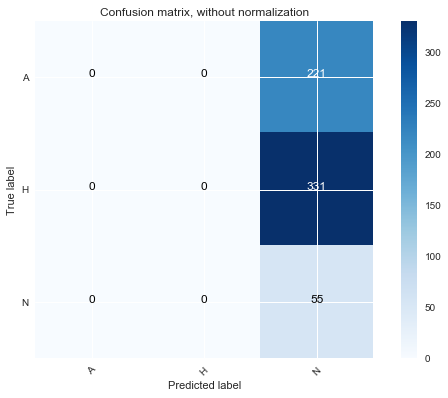

In [75]:
#Code repris entièrement des exemples scikit-learn

import itertools
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

class_names = ['A','H','N']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(vrai_resultats.vainqueur.values, vrai_resultats.prediction_vainqueur.values)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

Commentaires :
- Les résultats sont encourageant pour un modèle aussi simple (quasiment 50% de réussite, à comparer aux 33% d'une méthode complètement aléatoire)
- On prédit trop souvent Away : peut être que le modèle favorise trop l'équipe à domicile...

In [76]:
vrai_resultats.vainqueur.count()

607

In [77]:
vrai_resultats.vainqueur.value_counts() / vrai_resultats.vainqueur.count()

H    0.545305
A    0.364086
N    0.090610
Name: vainqueur, dtype: float64

prochaine étapes :
- améliorer le modèle hierarchique (prendre en compte les tirs cadrés, etc.)
- modéliser au niveau de chaque joueur ?
- écrire le code d'une simulation d'une saison entière pour obtenir le classement final

Enfin, on va compter le nombre de fois où notre projection de score est correcte

In [ ]:
score_juste = vrai_resultats[vrai_resultats.home_points == vrai_resultats.prediction_home_score]
score_juste = score_juste[vrai_resultats.away_points == vrai_resultats.prediction_away_score]
len(score_juste) / float(len(vrai_resultats))

On a prédit le bon score dans 14.5% des cas.

Par la suite, on améliorera le modèle selon 3 axes :
- les buts étant des évênements rares, ils sont soumis à une grande variabilité et peuvent donc être une métrique trompeuse. Il va donc falloir "l'augmenter" avec d'autres évênements moins rares, mais quasiment tout autant important : le nombre de tirs cadrés, non cadrés, corner, de pénaltis, etc.
- mieux charactériser les paramètres latents d'une équipe. On a ici résumé l'information disponible à un score d'attaque et un score de défense, mais il y en a certainement d'autres : la possession moyenne de balle par exemple ? ...
- mieux charactériser la situation du match, indépendement des performances d'une équipe : le fait de jouer à domicile a été pris en compte ici, mais on peut penser à d'autres choses, tels que le temps de repos depuis le dernier match, etc.
- prendre en compte l'évolution du style de jeu au cours des années (cf le notebook sur les buts vs loi de poisson)

Eventuellement plus tard modéliser au niveau du joueur

# Quelques analyses en plus 

In [190]:
def extract_time_elapsed(row):
    if(not pd.isnull(row)):
        tree = html.fromstring(row)
        coord = tree.xpath('//elapsed/text()')
        return np.array(coord, dtype=np.int32)
    return np.nan

match['time_elapsed'] = match.goal.apply(lambda row: extract_time_elapsed(row))

Regardons la distribution des buts par minute d'un match

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000068D1E8D0>]], dtype=object)

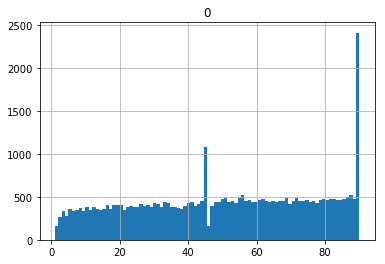

In [191]:
pd.DataFrame(np.hstack(match.time_elapsed.values)).hist(bins=90)

On observe beaucoup plus de buts à la 45ème et à la 90ème minutes ! En effet, les buts marqués pendants le temps additionel (91, 92, 93ème minutes) sont compté comme 90. Idem pour 45.

Etudions la position (distance + angle en degré) des tirs :

In [192]:
def extract_position_distance(row):
    if(not pd.isnull(row)):
        tree = html.fromstring(row)
        coord = tree.xpath('//coordinates/value/text()')
        return np.array(coord[0:][::2], dtype=np.int32)
    return np.nan

def extract_position_angle(row):
    if(not pd.isnull(row)):
        tree = html.fromstring(row)
        coord = tree.xpath('//coordinates/value/text()')
        return np.array(coord[1:][::2], dtype=np.int32)
    return np.nan

match['position_distance'] = match.goal.apply(lambda row: extract_position_distance(row))
match['position_angle'] = match.goal.apply(lambda row: extract_position_angle(row))

In [193]:
heatmap = pd.DataFrame([np.hstack(match.position_distance.values),np.hstack(match.position_angle.values)]).T
heatmap.dropna(inplace=True)
heatmap.columns = ['Distance', 'Angle']

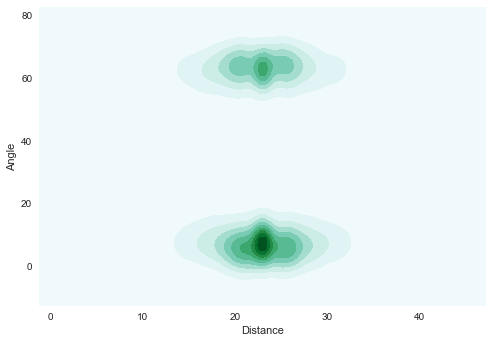

In [194]:
import seaborn
seaborn.kdeplot(heatmap.Distance, heatmap.Angle, shade=True)

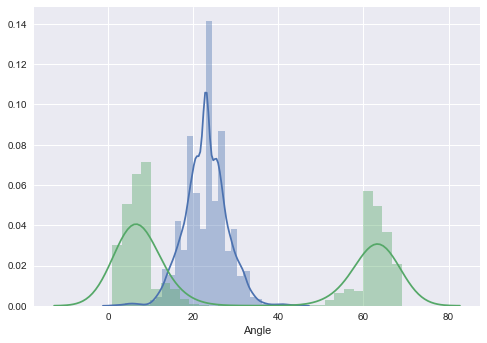

In [195]:
seaborn.distplot(heatmap.Distance, bins=30)
seaborn.distplot(heatmap.Angle, bins=30)